In [1]:
# Data Handling
import os
import json
import random
import pickle
import numpy as np
import pandas as pd
import scipy.io
from scipy.io import mmread

# Graph Processing
import networkx as nx
import dgl
import dgl.nn as dglnn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from node2vec import Node2Vec

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import scipy.stats as st

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# Embeddings 
from gensim.models import Word2Vec

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

In [2]:
datasets = {
    "Bitcoin Alpha": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-alpha.mtx",
    "Bitcoin OTC": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-otc.mtx",
    "Epinions": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx",
    "Slashdot": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-Slashdot081106.mtx"
}


In [3]:
# Load the matrix
epinions_matrix = mmread("soc-sign-epinions.mtx").tocoo()

# Convert to DataFrame
epinions_df = pd.DataFrame({
    'source': epinions_matrix.row,
    'target': epinions_matrix.col,
    'sign': epinions_matrix.data
})
epinions_df.head(10)

,source,target,sign
0,0,1,-1
1,130143,1,1
2,5079,2,1
3,2,3,1
4,116,3,1
5,3579,3,1
6,5079,3,1
7,7263,4,1
8,4,5,-1
9,5,5,1


In [4]:
print(epinions_df.head(10).to_latex(index=False))


\begin{tabular}{rrr}
\toprule
source & target & sign \\
\midrule
0 & 1 & -1 \\
130143 & 1 & 1 \\
5079 & 2 & 1 \\
2 & 3 & 1 \\
116 & 3 & 1 \\
3579 & 3 & 1 \\
5079 & 3 & 1 \\
7263 & 4 & 1 \\
4 & 5 & -1 \\
5 & 5 & 1 \\
\bottomrule
\end{tabular}



In [5]:
graphs = {}

for name, path in datasets.items():
    print(f" Loading dataset: {name} ...")
    mtx_data = scipy.io.mmread(path)
    G = nx.from_scipy_sparse_array(mtx_data, create_using=nx.Graph)
    graphs[name] = G
    print(f"{name} - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}\n")

 Loading dataset: Bitcoin Alpha ...
Bitcoin Alpha - Nodes: 3783, Edges: 14124

 Loading dataset: Bitcoin OTC ...
Bitcoin OTC - Nodes: 5881, Edges: 21492

 Loading dataset: Epinions ...
Epinions - Nodes: 131828, Edges: 711783

 Loading dataset: Slashdot ...
Slashdot - Nodes: 77357, Edges: 468554



In [6]:
degree_distributions = {}

for name, G in graphs.items():
    
    degree_dict = dict(G.degree())
    degree_series = pd.Series(degree_dict)

    # Save degree distribution
    degree_df = pd.DataFrame({"Node": list(G.nodes), "Degree": degree_series})
    degree_df.to_csv(f"{name}_degree_distribution.csv", index=False)

    degree_distributions[name] = degree_series.describe()

# Convert results to DataFrame
degree_summary_df = pd.DataFrame(degree_distributions)
print("\n Summary of Degree Distributions:")
print(degree_summary_df)


 Summary of Degree Distributions:
       Bitcoin Alpha  Bitcoin OTC       Epinions      Slashdot
count    3783.000000  5881.000000  131828.000000  77357.000000
mean        7.467090     7.308961      10.798662     12.114069
std        20.055671    23.039354      51.573440     40.393764
min         1.000000     1.000000       1.000000      0.000000
25%         1.000000     1.000000       1.000000      1.000000
50%         2.000000     2.000000       1.000000      2.000000
75%         6.000000     5.000000       4.000000      8.000000
max       511.000000   795.000000    3558.000000   2537.000000


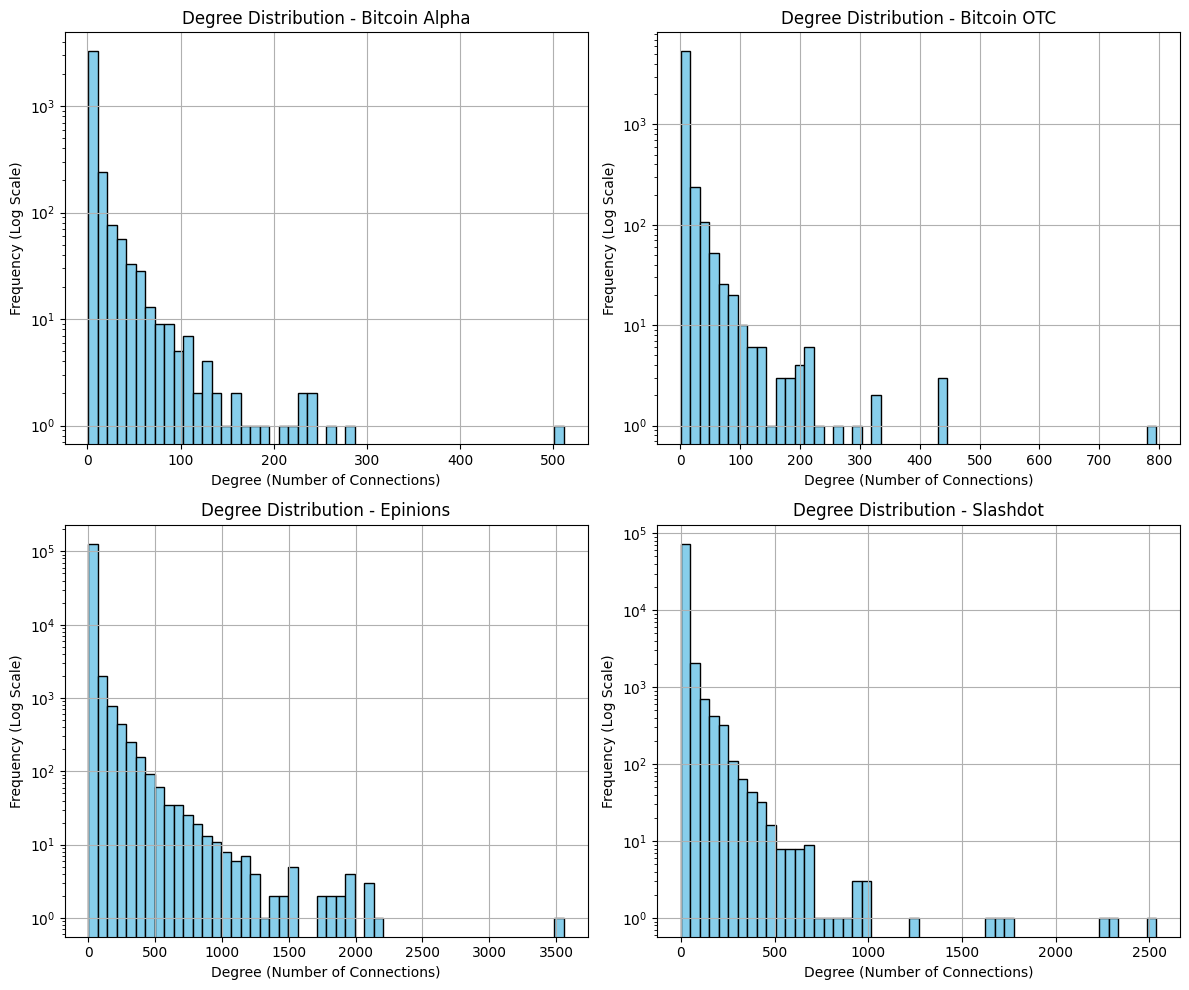

In [7]:
# Plot degree distributions for all datasets
plt.figure(figsize=(12, 10))

for i, (name, G) in enumerate(graphs.items(), 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    degree_sequence = [deg for _, deg in G.degree()]
    plt.hist(degree_sequence, bins=50, color='skyblue', edgecolor='black', log=True)
    plt.xlabel("Degree (Number of Connections)")
    plt.ylabel("Frequency (Log Scale)")
    plt.title(f"Degree Distribution - {name}")
    plt.grid(True)

plt.tight_layout()
plt.savefig("degree_distributions_all.pdf", dpi=300)
plt.show()


- Most nodes in all four networks have a low degree — this means that the majority of users are only sparsely connected (degree ≤ 10).
- The degree distributions are right-skewed, suggesting that only a few nodes act as highly connected hubs.
- This pattern is especially evident in **Epinions** and **Slashdot**, where some nodes have degrees in the thousands.
- Using a logarithmic scale for frequency improves the visualization of this skewed distribution and highlights the power-law-like behavior, which is common in social networks.

In [8]:
# Compute graph density for each dataset
for name, G in graphs.items():
    graph_density = nx.density(G)
    print(f"{name} - Number of Nodes: {G.number_of_nodes()}")
    print(f"{name} - Number of Edges: {G.number_of_edges()}")
    print(f"{name} - Graph Density: {graph_density:.4f}\n")



Bitcoin Alpha - Number of Nodes: 3783
Bitcoin Alpha - Number of Edges: 14124
Bitcoin Alpha - Graph Density: 0.0020

Bitcoin OTC - Number of Nodes: 5881
Bitcoin OTC - Number of Edges: 21492
Bitcoin OTC - Graph Density: 0.0012

Epinions - Number of Nodes: 131828
Epinions - Number of Edges: 711783
Epinions - Graph Density: 0.0001

Slashdot - Number of Nodes: 77357
Slashdot - Number of Edges: 468554
Slashdot - Graph Density: 0.0002



Graph density is a measure of how many connections exist in a network relative to the total possible connections. It is calculated as:

- **Bitcoin Alpha**: Density = 0.0020
- **Bitcoin OTC**: Density = 0.0012
- **Epinions**: Density = 0.0001
- **Slashdot**: Density = 0.0002

Interpretation:
- All networks are **very sparse**, meaning most nodes are not directly connected.
- **Epinions** and **Slashdot** are particularly sparse due to their very large number of nodes.
- This kind of sparsity is common in real-world social networks, where only a fraction of all possible connections are realized.



Potential features:

In [9]:
# List of potential feature files 
feature_files = {
    "Bitcoin Alpha Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-alpha_nodeid.mtx",
    "Bitcoin OTC Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-otc_nodeid.mtx"
}

In [10]:
# Try loading feature files
for name, path in feature_files.items():
    try:
        print(f"\nChecking features in: {name}")
        feature_data = scipy.io.mmread(path)
        
        # Convert to array and check shape
        feature_array = feature_data.toarray() if hasattr(feature_data, "toarray") else feature_data
        print(f"{name} - Shape: {feature_array.shape}")

        # Print first 5 node features 
        if len(feature_array) > 0:
            print(f"First 5 Nodes' Features: {feature_array[:5]}")

    except Exception as e:
        print(f"Error loading {name}: {e}")


Checking features in: Bitcoin Alpha Node IDs
Error loading Bitcoin Alpha Node IDs: Line 1: Not a Matrix Market file. Missing banner.

Checking features in: Bitcoin OTC Node IDs
Error loading Bitcoin OTC Node IDs: Line 1: Not a Matrix Market file. Missing banner.


the values indicate just a numerical index for nodes, not meaningful attributes.

Bitcoin Alpha - High-Degree Nodes: 402
Bitcoin Alpha - Low-Degree Nodes: 1368

Bitcoin OTC - High-Degree Nodes: 597
Bitcoin OTC - Low-Degree Nodes: 2260

Epinions - High-Degree Nodes: 13193
Epinions - Low-Degree Nodes: 67325

Slashdot - High-Degree Nodes: 7821
Slashdot - Low-Degree Nodes: 28191



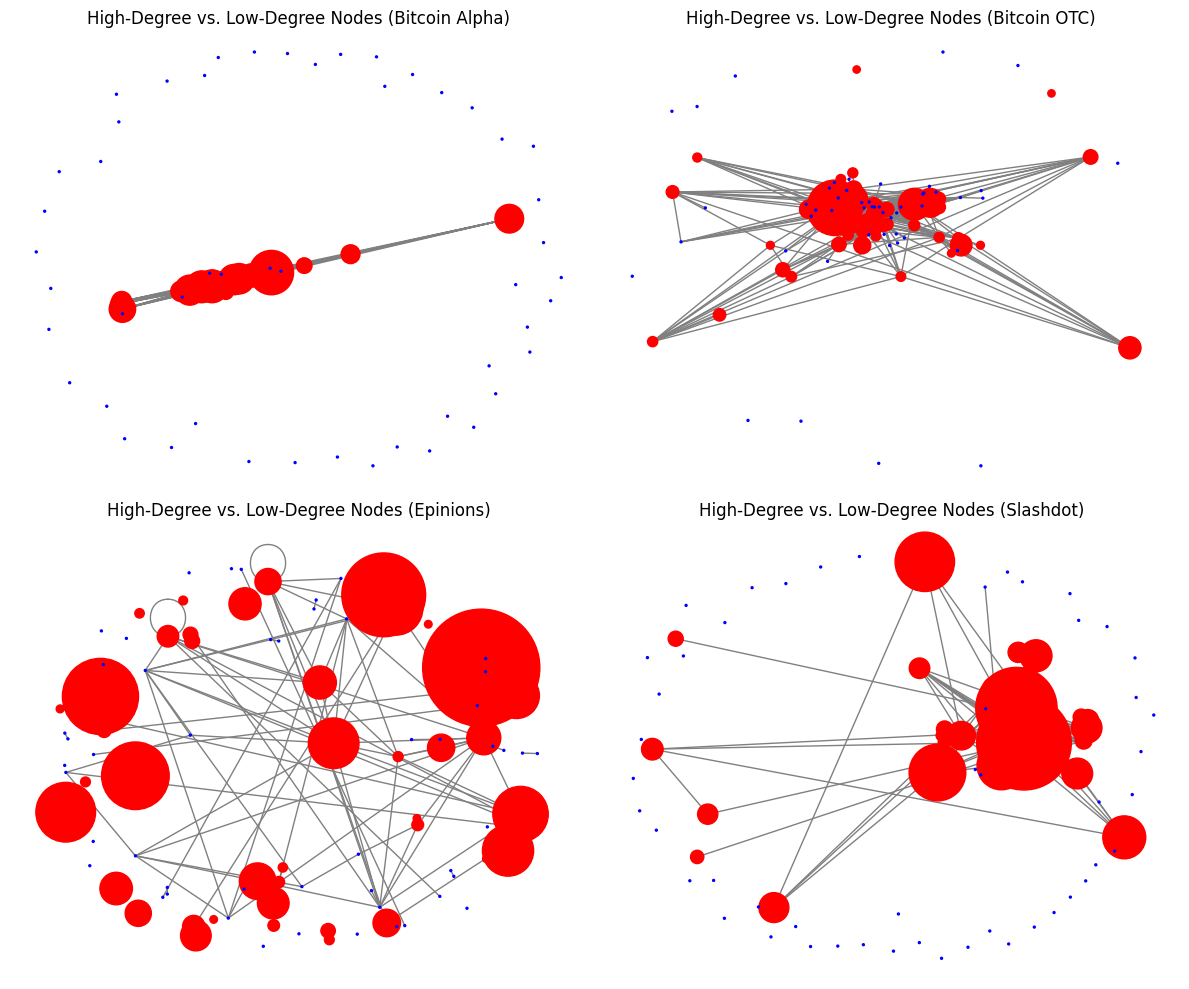

In [11]:
# Identify high-degree and low-degree nodes for each dataset
high_degree_nodes = {}
low_degree_nodes = {}

for name, G in graphs.items():
    degree_series = pd.Series(dict(G.degree()))

    # Define top 10% and bottom 10% threshold
    high_degree_threshold = degree_series.quantile(0.90)
    low_degree_threshold = degree_series.quantile(0.10)

    # Select nodes
    high_degree_nodes[name] = degree_series[degree_series >= high_degree_threshold].index
    low_degree_nodes[name] = degree_series[degree_series <= low_degree_threshold].index

    print(f"{name} - High-Degree Nodes: {len(high_degree_nodes[name])}")
    print(f"{name} - Low-Degree Nodes: {len(low_degree_nodes[name])}\n")

# Create a 2x2 plot for visualizing all datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, G) in enumerate(graphs.items()):
    # Sample 50 high-degree and 50 low-degree nodes
    subgraph_nodes = list(high_degree_nodes[name][:50]) + list(low_degree_nodes[name][:50])
    subG = G.subgraph(subgraph_nodes)

    # Define node colors: red for high-degree, blue for low-degree
    color_map = ['red' if node in high_degree_nodes[name] else 'blue' for node in subgraph_nodes]

    # Define node sizes based on degree
    node_sizes = [G.degree(n) * 2 for n in subgraph_nodes]

    # Plot the subgraph
    plt.sca(axes[i])
    nx.draw(subG, node_color=color_map, node_size=node_sizes, edge_color="gray")
    plt.title(f"High-Degree vs. Low-Degree Nodes ({name})")

plt.tight_layout()
plt.show()


- **Red nodes** represent **high-degree** nodes (top 10% by connectivity).
- **Blue nodes** represent **low-degree** nodes (bottom 10% by connectivity).
- **Node size is proportional to its degree** — more connected nodes appear larger.

#### Key Observations:

- **Bitcoin Alpha**:  
  High-degree nodes (red) are centrally clustered, often connecting to each other. Low-degree nodes (blue) are more peripheral and mostly disconnected, forming a hub-and-spoke pattern.

- **Bitcoin OTC**:  
  Displays a dense core of high-degree nodes, with low-degree nodes still somewhat connected to this core. A more cohesive structure compared to Bitcoin Alpha.

- **Epinions**:  
  Shows rich interconnectivity across both high- and low-degree nodes. The subgraph is dense, indicating a more egalitarian interaction pattern where even low-degree nodes are somewhat connected.

- **Slashdot**:  
  High-degree nodes form a dense and centralized cluster. Low-degree nodes are loosely attached, many appearing isolated. The contrast in connectivity is visually stark.

These patterns reveal important network dynamics, such as whether influence is concentrated in a few "hub" nodes or more evenly distributed. High-degree nodes tend to serve as connectors, and their spatial clustering shows how centralized each network is.


# Full graph experiments

# Baseline

In [ ]:
# GAE Model
class GCNEncoder(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

    def forward(self, graph, features):
        h = F.relu(self.conv1(graph, features))
        return self.conv2(graph, h)

class MLPDecoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim * 2, in_dim)
        self.fc2 = nn.Linear(in_dim, 1)

    def forward(self, z, edges):
        src, dst = edges[:, 0], edges[:, 1]
        h = torch.cat([z[src], z[dst]], dim=1)
        h = F.elu(self.fc1(h))
        return torch.sigmoid(self.fc2(h)).squeeze()

class GAE(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super().__init__()
        self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
        self.decoder = MLPDecoder(out_dim)

    def forward(self, graph, features, edges):
        z = self.encoder(graph, features)
        return self.decoder(z, edges)

# One run
def epinions_baseline():
    mtx = scipy.io.mmread("/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx").tocoo()
    src = torch.tensor(mtx.row, dtype=torch.long)
    dst = torch.tensor(mtx.col, dtype=torch.long)
    edge_signs = torch.tensor(mtx.data, dtype=torch.float)

    graph = dgl.graph((src, dst), num_nodes=max(src.max(), dst.max()).item() + 1)
    graph.edata['sign'] = edge_signs
    graph = dgl.add_self_loop(graph)

    # Compute signed node features
    num_nodes = graph.num_nodes()
    pos_deg = torch.zeros(num_nodes)
    neg_deg = torch.zeros(num_nodes)
    for s, d, sign in zip(src, dst, edge_signs):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    # Sample random negative edges (not hard negatives)
    def sample_random_negative_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            edges = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(edges.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    pos_edges = torch.stack((src, dst), dim=1)
    neg_edges = sample_random_negative_edges(graph, len(pos_edges))

    # Split
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)

    train_edges = torch.cat([pos_train, neg_train], dim=0)
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test], dim=0)
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Train model
    model = GAE(2, 128, 64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        test_preds = model(graph, features, test_edges).numpy()
    pred_labels = (test_preds > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness
    degs = graph.in_degrees().numpy()
    node_degrees = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    bins = np.percentile(node_degrees, [0, 50, 100])
    bin_ids = np.digitize(node_degrees, bins[1:-1])

    degree_auc = []
    dp_vals = []
    eo_vals = []
    for i in range(2):
        idx = np.where(bin_ids == i)[0]
        if len(idx) == 0:
            continue
        degree_auc.append(roc_auc_score(test_labels[idx], test_preds[idx]))
        dp_vals.append(np.mean(pred_labels[idx]))
        y_true, y_pred = test_labels[idx], pred_labels[idx]
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            eo_vals.append(tp / (tp + fn + 1e-8))
        else:
            eo_vals.append(0)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": max(degree_auc) - min(degree_auc),
        "DP Gap": max(dp_vals) - min(dp_vals),
        "EO Gap": max(eo_vals) - min(eo_vals)
    }

# 10 runs
results = [epinions_baseline() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.919701  0.859872   0.870809  0.851419  0.858943    0.215824  0.599196   
std   0.019479  0.028499   0.055425  0.044656  0.025020    0.094191  0.061978   

        EO Gap  
mean  0.503534  
std   0.154114  

95% Confidence Intervals:
AUC: 0.9197 ± 0.0139
Accuracy: 0.8599 ± 0.0204
Precision: 0.8708 ± 0.0396
Recall: 0.8514 ± 0.0319
F1: 0.8589 ± 0.0179
Degree Gap: 0.2158 ± 0.0674
DP Gap: 0.5992 ± 0.0443
EO Gap: 0.5035 ± 0.1102


### **Evaluation Metrics**

- The model achieved **very strong predictive performance**, with an AUC-ROC that reflects its excellent ability to distinguish between real and fake links.
- **Accuracy, precision, recall, and F1 scores were all high and consistent**, demonstrating that the model performs reliably on both positive and negative samples.
- The performance leaned slightly toward precision, indicating the model prioritizes correctness in its positive predictions and avoids false positives.
- Overall, the model shows a well-rounded and stable classification performance, making it a strong benchmark for comparison.

### **Fairness Metrics**

- **Degree Fairness** revealed a **moderate disparity**, meaning the model’s predictive behavior varies somewhat between high- and low-degree nodes.
- **Demographic Parity** exhibited a **substantial imbalance**, implying that one node group received significantly more positive predictions, regardless of actual edge labels.
- **Equalized Odds** also showed a **notable fairness gap**, suggesting that true positive rates differ considerably across node groups — a key fairness concern in graph-based applications.


# FairDrop 

In [56]:
def apply_fairdrop(graph, sensitive_attr, drop_prob=0.5):
    src, dst = graph.edges()
    edge_mask = []

    for u, v in zip(src.tolist(), dst.tolist()):
        if sensitive_attr[u] == sensitive_attr[v] and sensitive_attr[u] != -1:
            keep = np.random.rand() > drop_prob
        else:
            keep = True
        edge_mask.append(keep)

    edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
    new_src = src[edge_mask]
    new_dst = dst[edge_mask]

    fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())
    if 'sign' in graph.edata:
        fair_graph.edata['sign'] = graph.edata['sign'][edge_mask]
    return fair_graph


def fairdrop_epinions(drop_prob=0.5):
    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    src = torch.tensor(mtx.row, dtype=torch.long)
    dst = torch.tensor(mtx.col, dtype=torch.long)
    edge_signs = torch.tensor(mtx.data, dtype=torch.float)

    graph = dgl.graph((src, dst), num_nodes=max(src.max(), dst.max()).item() + 1)
    graph.edata['sign'] = edge_signs
    graph = dgl.add_self_loop(graph)

    # Node features
    num_nodes = graph.num_nodes()
    pos_deg = torch.zeros(num_nodes)
    neg_deg = torch.zeros(num_nodes)
    for s, d, sign in zip(src, dst, edge_signs):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    # Sensitive attribute
    degrees = graph.in_degrees()
    mean_deg = degrees.float().mean()
    sensitive_attr = torch.where(degrees <= mean_deg, 0, 1).numpy()

    # Apply FairDrop
    fair_graph = apply_fairdrop(graph, sensitive_attr, drop_prob)
    if fair_graph.num_edges() == 0:
        print("FairDrop resulted in an empty graph — skipping this run.")
        return None

    # Sample negative edges (random)
    def sample_neg_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    pos_edges = torch.stack((src, dst), dim=1)
    neg_edges = sample_neg_edges(graph, len(pos_edges))

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)

    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Train
    model = GAE(2, 128, 64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(fair_graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        test_preds = model(fair_graph, features, test_edges).numpy()
    pred_labels = (test_preds > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness
    node_degrees = [min(degrees[u], degrees[v]) for u, v in test_edges.numpy()]
    bins = np.percentile(node_degrees, [0, 50, 100])
    bin_ids = np.digitize(node_degrees, bins[1:-1])

    degree_auc, dp_vals, eo_vals = [], [], []
    for i in range(2):
        idx = np.where(bin_ids == i)[0]
        if len(idx) == 0: continue
        degree_auc.append(roc_auc_score(test_labels[idx], test_preds[idx]))
        dp_vals.append(np.mean(pred_labels[idx]))
        y_true, y_pred = test_labels[idx], pred_labels[idx]
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            eo_vals.append(tp / (tp + fn + 1e-8))
        else:
            eo_vals.append(0)

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1": f1,
        "Degree Gap": max(degree_auc) - min(degree_auc),
        "DP Gap": max(dp_vals) - min(dp_vals),
        "EO Gap": max(eo_vals) - min(eo_vals)
    }


# Run and filter valid results
raw_results = [fairdrop_epinions(drop_prob=0.5) for _ in range(10)]
results = [r for r in raw_results if r is not None]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.913010  0.860907   0.898236  0.818021  0.852903    0.238671  0.584664   
std   0.027944  0.024848   0.033858  0.078270  0.037553    0.075966  0.070520   

        EO Gap  
mean  0.536994  
std   0.124520  

95% Confidence Intervals:
AUC: 0.9130 ± 0.0200
Accuracy: 0.8609 ± 0.0178
Precision: 0.8982 ± 0.0242
Recall: 0.8180 ± 0.0560
F1: 0.8529 ± 0.0269
Degree Gap: 0.2387 ± 0.0543
DP Gap: 0.5847 ± 0.0504
EO Gap: 0.5370 ± 0.0891


### **Evaluation Metrics**

- The **overall classification performance of FairDrop remained strong**, with metrics such as AUC, precision, and F1 comparable to the baseline.
- **Accuracy and recall were slightly lower than the baseline**, indicating a modest reduction in the model's ability to identify true positive links.
- **Precision remained consistent**, showing that the classifier continues to avoid false positives effectively, even after FairDrop's edge filtering.
- Despite minor performance drops, FairDrop still delivers **high-quality predictions**, making it a robust fairness-aware alternative.

### **Fairness Metrics**

- **Degree Fairness was nearly identical to the baseline**, suggesting that FairDrop does not significantly change how the model handles nodes with different degrees.
- **Demographic Parity was also similarly imbalanced**, meaning FairDrop did not mitigate the skew in the predicted positive rates across groups.
- **Equalized Odds was slightly better**, showing a small improvement in the balance of true positive rates between groups compared to the baseline.



# FairWalk 

In [ ]:
def generate_and_save_fairwalk_embeddings():
    mtx = scipy.io.mmread("soc-sign-epinions.mtx")
    graph = nx.from_scipy_sparse_array(mtx, create_using=nx.DiGraph)
    
    # Assign sensitive attributes based on mean degree
    degrees = np.array([graph.degree(n) for n in graph.nodes()])
    mean_deg = degrees.mean()
    attr_dict = {node: 0 if graph.degree(node) <= mean_deg else 1 for node in graph.nodes()}

    def generate_fairwalks(graph, attr_dict, num_walks=10, walk_length=20):
        walks = []
        nodes = list(graph.nodes())
        for _ in tqdm(range(num_walks), desc="Generating FairWalks"):
            np.random.shuffle(nodes)
            for node in nodes:
                walk = [node]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    next_node = np.random.choice(opp_group if opp_group else neighbors)
                    walk.append(next_node)
                walks.append([str(n) for n in walk])
        return walks

    # Generate walks and train Word2Vec
    walks = generate_fairwalks(graph, attr_dict)
    model = Word2Vec(
        sentences=walks, vector_size=32, window=5,
        min_count=0, sg=1, workers=4, epochs=5
    )

    # Store embeddings and attributes
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}
    with open("fairwalk_epinions_embeddings.pkl", "wb") as f:
        pickle.dump((embeddings, attr_dict), f)

generate_and_save_fairwalk_embeddings()

# One run
def fairwalk_epinions():
    # Load precomputed embeddings and sensitive attribute mapping
    with open("fairwalk_epinions_embeddings.pkl", "rb") as f:
        embeddings, attr_dict = pickle.load(f)

    # Load Epinions graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx")
    graph = nx.from_scipy_sparse_array(mtx, create_using=nx.DiGraph)

    # Sample 5k positive edges
    all_pos_edges = list(graph.edges())
    pos_edges = random.sample(all_pos_edges, 5000)

    # Sample 5k random negative edges
    nodes = list(graph.nodes())
    neg_edges = []
    while len(neg_edges) < len(pos_edges):
        u, v = np.random.choice(nodes, 2)
        if not graph.has_edge(u, v):
            neg_edges.append((u, v))

    # Feature construction
    def create_features(edges, label):
        X, y, kept_edges = [], [], []
        for u, v in edges:
            if u in embeddings and v in embeddings:
                X.append(np.concatenate([embeddings[u], embeddings[v]]))
                y.append(label)
                kept_edges.append((u, v))
        return X, y, kept_edges

    X_pos, y_pos, kept_pos = create_features(pos_edges, 1)
    X_neg, y_neg, kept_neg = create_features(neg_edges, 0)

    X = np.array(X_pos + X_neg)
    y = np.array(y_pos + y_neg)
    edge_list = kept_pos + kept_neg

    # Shuffle and split
    X, y, edge_list = shuffle(X, y, edge_list)
    X_train, X_test, y_train, y_test, edge_train, edge_test = train_test_split(
        X, y, edge_list, test_size=0.2
    )

    # Train classifier
    clf = LogisticRegression(max_iter=300)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    # Standard metrics
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness 
    edge_deg = [max(attr_dict[u], attr_dict[v]) for u, v in edge_test]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    p_high = np.mean(y_proba[high_mask])
    p_low = np.mean(y_proba[low_mask])
    degree_gap = abs(p_high - p_low)

    dp_gap = abs(np.mean(y_pred[high_mask]) - np.mean(y_pred[low_mask]))

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# 10 runs
results = [fairwalk_epinions() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(['mean', 'std']))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")



Generating FairWalks: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]



Metric Means and Standard Deviations:
          AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.83393  0.768750   0.778765  0.746431  0.762178    0.330800  0.522658   
std   0.00894  0.010719   0.016827  0.008185  0.010147    0.009567  0.013178   

        EO Gap  
mean  0.455129  
std   0.062515  

95% Confidence Intervals:
AUC: 0.8339 ± 0.0064
Accuracy: 0.7688 ± 0.0077
Precision: 0.7788 ± 0.0120
Recall: 0.7464 ± 0.0059
F1: 0.7622 ± 0.0073
Degree Gap: 0.3308 ± 0.0068
DP Gap: 0.5227 ± 0.0094
EO Gap: 0.4551 ± 0.0447


### Evaluation Metrics

- Compared to the baseline, FairWalk shows a **notable drop in overall predictive performance**. Metrics such as AUC, accuracy, and F1 score were consistently lower, suggesting that the model is less effective at distinguishing between positive and negative edges.
- Precision remained relatively stable across both models, indicating FairWalk's ability to make reliable positive predictions, though its **recall decreased**, suggesting it may miss a greater proportion of true links.
- This performance trade-off reflects FairWalk’s design goal: prioritizing fairness over optimal predictive power.

### Fairness Metrics

- **Degree Fairness worsened significantly** in FairWalk. The gap between high- and low-degree node predictions grew substantially, meaning the model’s predictions are **less equitable across degree groups** compared to the baseline.
- **Demographic Parity improved slightly**, showing reduced bias in the rate of positive predictions across groups — though both models show relatively high disparity here.
- **Equalized Odds remained comparable** between FairWalk and the baseline, indicating that true positive rates across degree-based groups are similarly imbalanced.




# FairAdj 

In [ ]:
# One run 
def fairadj_epinions(drop_rate=0.5, sample_size=5000):
    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    G = nx.from_edgelist(zip(mtx.row, mtx.col))

    # Sensitive attribute based on degree
    degrees = np.array([G.degree(n) for n in G.nodes()])
    mean_deg = degrees.mean()
    sensitive_attr = {node: int(G.degree(node) > mean_deg) for node in G.nodes()}

    # FairAdj edge filtering
    edges = list(G.edges())
    fair_edges = []
    for u, v in edges:
        same_group = sensitive_attr[u] == sensitive_attr[v]
        if not same_group or random.random() > drop_rate:
            fair_edges.append((u, v))
    fair_nx_graph = nx.from_edgelist(fair_edges)

    # Positive and negative edge sampling
    edges_pos = random.sample(list(fair_nx_graph.edges()), sample_size)
    edges_neg = []
    while len(edges_neg) < sample_size:
        u, v = random.sample(list(fair_nx_graph.nodes()), 2)
        if not fair_nx_graph.has_edge(u, v):
            edges_neg.append((u, v))

    labels_pos = [1] * sample_size
    labels_neg = [0] * sample_size

    # Combine and split
    all_edges = edges_pos + edges_neg
    all_labels = labels_pos + labels_neg
    X_edges, y = shuffle(all_edges, all_labels)
    train_edges, test_edges, train_labels, test_labels = train_test_split(
        X_edges, y, test_size=0.2
    )

    # Subgraph + Node2Vec
    train_nodes = list(set([n for edge in train_edges for n in edge]))
    subgraph = fair_nx_graph.subgraph(train_nodes).copy()
    node2vec = Node2Vec(
        subgraph,
        dimensions=32,
        walk_length=20,
        num_walks=10,
        workers=4
    )
    w2v_model = node2vec.fit(window=5, min_count=1, batch_words=4, epochs=5)
    embeddings = {str(n): w2v_model.wv[str(n)] for n in subgraph.nodes()}

    # Filter and embed edges
    def embed_edges(edge_list, labels):
        X, y, keep = [], [], []
        for (u, v), label in zip(edge_list, labels):
            if str(u) in embeddings and str(v) in embeddings:
                X.append(np.concatenate([embeddings[str(u)], embeddings[str(v)]]))
                y.append(label)
                keep.append((u, v))
        return np.array(X), np.array(y), keep

    X_train, y_train, train_edges = embed_edges(train_edges, train_labels)
    X_test, y_test, test_edges = embed_edges(test_edges, test_labels)

    # Train and predict
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)

    # Metrics
    auc = roc_auc_score(y_test, y_scores)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness
    edge_deg = [max(sensitive_attr[u], sensitive_attr[v]) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    p_high = np.mean(y_scores[high_mask])
    p_low = np.mean(y_scores[low_mask])
    degree_gap = abs(p_high - p_low)

    dp_gap = abs(np.mean(y_pred[high_mask]) - np.mean(y_pred[low_mask]))

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# Run 10x
results = [fairadj_epinions() for _ in range(10)]
df = pd.DataFrame(results)

# Show summary
print("\nMetric Means and Standard Deviations:")
print(df.agg(['mean', 'std']))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")


Generating walks (CPU: 4): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]



Metric Means and Standard Deviations:
          AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.80716  0.944723   0.978149  0.963508  0.970640    0.520380  0.734049   
std   0.08873  0.010631   0.009682  0.015942  0.005752    0.177782  0.205789   

        EO Gap  
mean  0.877123  
std   0.285947  

95% Confidence Intervals:
AUC: 0.8072 ± 0.0635
Accuracy: 0.9447 ± 0.0076
Precision: 0.9781 ± 0.0069
Recall: 0.9635 ± 0.0114
F1: 0.9706 ± 0.0041
Degree Gap: 0.5204 ± 0.1272
DP Gap: 0.7340 ± 0.1472
EO Gap: 0.8771 ± 0.2046


### Evaluation Metrics

- **FairAdj exhibited a sharp drop in AUC-ROC** compared to the baseline, suggesting that the model’s ability to distinguish between real and fake links was significantly compromised.
- Despite this, **precision remained extremely high**, indicating the model was confident when it did make positive predictions — though this may reflect **over-conservatism** rather than genuine accuracy.
- **Recall was notably lower than the baseline**, showing that the FairAdj model missed more true positive edges.
- Interestingly, **F1 score remained comparable** to the baseline due to the strong precision balancing the reduced recall.

### Fairness Metrics

- **Degree Fairness was slightly worse** than baseline, indicating increased disparity in prediction confidence across node degree groups.
- **Demographic Parity improved somewhat**, suggesting a more balanced distribution of predicted positives across groups.
- However, **Equalized Odds worsened substantially**, showing a notable increase in recall disparity between groups — a key fairness concern.



# Subgraph Experiments


# Baseline

## Low degree nodes 

In [ ]:
def epinions_low_degree_baseline():
    # Load Epinions matrix and convert to DataFrame like Facebook
    mtx = scipy.io.mmread("/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    num_nodes = max(edges["src"].max(), edges["dst"].max()) + 1

    # Build full graph and compute degrees
    full_graph = dgl.graph((edges["src"], edges["dst"]), num_nodes=num_nodes)
    degrees = full_graph.in_degrees().numpy()
    node_ids = np.arange(num_nodes)

    # Select top_k low-degree nodes
    low_degree_nodes = node_ids[np.argsort(degrees)[:10000]]
    mask = np.isin(edges["src"], low_degree_nodes) & np.isin(edges["dst"], low_degree_nodes)
    sub_edges = edges[mask].copy()
    sub_src, sub_dst, sub_signs = sub_edges["src"].values, sub_edges["dst"].values, sub_edges["sign"].values

    # Reindex
    node_map = {old: new for new, old in enumerate(low_degree_nodes)}
    sub_src = np.array([node_map[s] for s in sub_src])
    sub_dst = np.array([node_map[d] for d in sub_dst])

    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(low_degree_nodes))
    sub_graph.edata["sign"] = torch.tensor(sub_signs, dtype=torch.float32)

    # Signed degree features
    pos_deg = torch.zeros(sub_graph.num_nodes())
    neg_deg = torch.zeros(sub_graph.num_nodes())
    for s, d, sign in zip(sub_src, sub_dst, sub_signs):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    def sample_negative_edges(graph, n_samples):
        neg_edges = []
        while len(neg_edges) < n_samples:
            u = torch.randint(0, graph.num_nodes(), (n_samples,))
            v = torch.randint(0, graph.num_nodes(), (n_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:n_samples], dtype=torch.long)

    pos_edges = torch.tensor(np.column_stack((sub_src, sub_dst)), dtype=torch.long)
    neg_edges = sample_negative_edges(sub_graph, len(pos_edges))

    if len(pos_edges) == 0:
        return None

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # GAE model definition
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

        def forward(self, g, x):
            h = F.relu(self.conv1(g, x))
            return self.conv2(g, h)

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)

        def forward(self, z, edges):
            src, dst = edges[:, 0], edges[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)

        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    model = GAE(2, 128, 64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(sub_graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_preds = model(sub_graph, features, test_edges).numpy()
    pred_labels = (test_preds > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    degs = sub_graph.in_degrees().numpy()
    edge_deg = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    threshold = np.mean(edge_deg)
    bin_idx = np.array([0 if d <= threshold else 1 for d in edge_deg])

    degree_scores, proportions, recalls = [], [], []
    for i in range(2):
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0:
            continue
        y_true = test_labels[idx]
        y_pred = pred_labels[idx]
        y_prob = test_preds[idx]

        if len(np.unique(y_true)) > 1:
            degree_scores.append(roc_auc_score(y_true, y_prob))
        proportions.append(np.mean(y_pred))
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    degree_gap = max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else 0.0
    dp_gap = max(proportions) - min(proportions) if len(proportions) >= 2 else 0.0
    eo_gap = max(recalls) - min(recalls) if len(recalls) >= 2 else 0.0

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": degree_gap, "DP Gap": dp_gap, "EO Gap": eo_gap
    }
# 10 runs
results = [epinions_low_degree_baseline() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.922155  0.860179   0.891059  0.829495  0.855540    0.207559  0.583444   
std   0.010609  0.017679   0.059554  0.061222  0.017394    0.082230  0.053299   

        EO Gap  
mean  0.510982  
std   0.126720  

95% Confidence Intervals:
AUC: 0.9222 ± 0.0076
Accuracy: 0.8602 ± 0.0126
Precision: 0.8911 ± 0.0426
Recall: 0.8295 ± 0.0438
F1: 0.8555 ± 0.0124
Degree Gap: 0.2076 ± 0.0588
DP Gap: 0.5834 ± 0.0381
EO Gap: 0.5110 ± 0.0907


## High degree nodes 

In [ ]:
def epinions_high_degree_baseline():
    # Load Epinions matrix and convert to DataFrame
    mtx = scipy.io.mmread("/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    num_nodes = max(edges["src"].max(), edges["dst"].max()) + 1

    # Build full graph and compute degrees
    full_graph = dgl.graph((edges["src"], edges["dst"]), num_nodes=num_nodes)
    degrees = full_graph.in_degrees().numpy()
    node_ids = np.arange(num_nodes)

    # Select top_k high-degree nodes
    high_degree_nodes = node_ids[np.argsort(degrees)[-10000:]]
    mask = np.isin(edges["src"], high_degree_nodes) & np.isin(edges["dst"], high_degree_nodes)
    sub_edges = edges[mask].copy()
    sub_src, sub_dst, sub_signs = sub_edges["src"].values, sub_edges["dst"].values, sub_edges["sign"].values

    # Reindex
    node_map = {old: new for new, old in enumerate(high_degree_nodes)}
    sub_src = np.array([node_map[s] for s in sub_src])
    sub_dst = np.array([node_map[d] for d in sub_dst])

    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(high_degree_nodes))
    sub_graph.edata["sign"] = torch.tensor(sub_signs, dtype=torch.float32)

    # Signed degree features
    pos_deg = torch.zeros(sub_graph.num_nodes())
    neg_deg = torch.zeros(sub_graph.num_nodes())
    for s, d, sign in zip(sub_src, sub_dst, sub_signs):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    def sample_negative_edges(graph, n_samples):
        neg_edges = []
        while len(neg_edges) < n_samples:
            u = torch.randint(0, graph.num_nodes(), (n_samples,))
            v = torch.randint(0, graph.num_nodes(), (n_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:n_samples], dtype=torch.long)

    pos_edges = torch.tensor(np.column_stack((sub_src, sub_dst)), dtype=torch.long)
    neg_edges = sample_negative_edges(sub_graph, len(pos_edges))

    if len(pos_edges) == 0:
        return None

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # GAE model definition
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

        def forward(self, g, x):
            h = F.relu(self.conv1(g, x))
            return self.conv2(g, h)

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)

        def forward(self, z, edges):
            src, dst = edges[:, 0], edges[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)

        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    model = GAE(2, 128, 64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(sub_graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_preds = model(sub_graph, features, test_edges).numpy()
    pred_labels = (test_preds > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    degs = sub_graph.in_degrees().numpy()
    edge_deg = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    threshold = np.mean(edge_deg)
    bin_idx = np.array([0 if d <= threshold else 1 for d in edge_deg])

    degree_scores, proportions, recalls = [], [], []
    for i in range(2):
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0:
            continue
        y_true = test_labels[idx]
        y_pred = pred_labels[idx]
        y_prob = test_preds[idx]

        if len(np.unique(y_true)) > 1:
            degree_scores.append(roc_auc_score(y_true, y_prob))
        proportions.append(np.mean(y_pred))
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    degree_gap = max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else 0.0
    dp_gap = max(proportions) - min(proportions) if len(proportions) >= 2 else 0.0
    eo_gap = max(recalls) - min(recalls) if len(recalls) >= 2 else 0.0

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": degree_gap, "DP Gap": dp_gap, "EO Gap": eo_gap
    }
# 10 runs
results = [epinions_high_degree_baseline() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.919404  0.858686   0.886904  0.830209  0.853934    0.200335  0.571562   
std   0.011468  0.014855   0.053498  0.066356  0.018628    0.086593  0.061534   

        EO Gap  
mean  0.462664  
std   0.108424  

95% Confidence Intervals:
AUC: 0.9194 ± 0.0082
Accuracy: 0.8587 ± 0.0106
Precision: 0.8869 ± 0.0383
Recall: 0.8302 ± 0.0475
F1: 0.8539 ± 0.0133
Degree Gap: 0.2003 ± 0.0619
DP Gap: 0.5716 ± 0.0440
EO Gap: 0.4627 ± 0.0776


# Fairdrop

## Low degree nodes

In [57]:
def epinions_low_degree_fairdrop(drop_prob=0.5, num_nodes_pool=20000, num_nodes_final=10000, debug=False):
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    total_nodes = max(edges["src"].max(), edges["dst"].max()) + 1
    degrees = dgl.graph((edges["src"], edges["dst"]), num_nodes=total_nodes).in_degrees().numpy()
    low_degree_nodes = np.argsort(degrees)[:num_nodes_pool]
    mask = np.isin(edges["src"], low_degree_nodes) | np.isin(edges["dst"], low_degree_nodes)
    sub_edges = edges[mask].copy()

    connected_nodes = np.unique(np.concatenate([sub_edges["src"].values, sub_edges["dst"].values]))
    if len(connected_nodes) < num_nodes_final:
        if debug: print("Too few connected nodes.")
        return None

    selected_nodes = np.random.choice(connected_nodes, size=num_nodes_final, replace=False)
    node_map = {old: new for new, old in enumerate(selected_nodes)}
    final_mask = np.isin(sub_edges["src"], selected_nodes) & np.isin(sub_edges["dst"], selected_nodes)
    final_edges = sub_edges[final_mask].copy()

    sub_src = np.array([node_map[s] for s in final_edges["src"]])
    sub_dst = np.array([node_map[d] for d in final_edges["dst"]])
    sub_signs = final_edges["sign"].values
    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=num_nodes_final)
    sub_graph.edata["sign"] = torch.tensor(sub_signs, dtype=torch.float32)

    degrees_sub = sub_graph.in_degrees().numpy()
    mean_deg = degrees_sub.mean()
    sensitive_attr = np.where(degrees_sub <= mean_deg, 0, 1)

    def apply_fairdrop(graph, sensitive_attr, drop_prob):
        src, dst = graph.edges()
        mask = []
        for u, v in zip(src.tolist(), dst.tolist()):
            if sensitive_attr[u] == sensitive_attr[v]:
                keep = np.random.rand() > drop_prob
            else:
                keep = True
            mask.append(keep)
        mask = torch.tensor(mask)
        new_src = src[mask]
        new_dst = dst[mask]
        fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())
        if "sign" in graph.edata:
            fair_graph.edata["sign"] = graph.edata["sign"][mask]
        return fair_graph

    fair_graph = apply_fairdrop(sub_graph, sensitive_attr, drop_prob)
    if fair_graph.num_edges() == 0:
        return None

    fair_graph = dgl.add_self_loop(fair_graph)

    if debug:
        print(f"Original edges: {sub_graph.num_edges()}, After FairDrop: {fair_graph.num_edges()}")

    # Features
    pos_deg = torch.zeros(fair_graph.num_nodes())
    neg_deg = torch.zeros(fair_graph.num_nodes())
    for s, d, sign in zip(*fair_graph.edges(), fair_graph.edata["sign"]):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    def sample_neg(graph, n):
        neg_edges = []
        while len(neg_edges) < n:
            u = torch.randint(0, graph.num_nodes(), (n,))
            v = torch.randint(0, graph.num_nodes(), (n,))
            mask = ~graph.has_edges_between(u, v)
            pairs = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(pairs.tolist())
        return torch.tensor(neg_edges[:n])

    src, dst = fair_graph.edges()
    pos_edges = torch.stack((src, dst), dim=1)
    if len(pos_edges) == 0: return None
    neg_edges = sample_neg(fair_graph, len(pos_edges))

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # GAE Model
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden, out):
            super().__init__()
            self.conv1 = dglnn.GraphConv(in_feats, hidden, allow_zero_in_degree=True)
            self.conv2 = dglnn.GraphConv(hidden, out, allow_zero_in_degree=True)
        def forward(self, g, x):
            return self.conv2(g, F.relu(self.conv1(g, x)))

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)
        def forward(self, z, edges):
            src, dst = edges[:, 0], edges[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden, out):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden, out)
            self.decoder = MLPDecoder(out)
        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    model = GAE(2, 128, 64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()
    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(model(fair_graph, features, train_edges), train_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_score = model(fair_graph, features, test_edges).numpy()
    y_pred = (y_score > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), y_score)
    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)

    degs = fair_graph.in_degrees().numpy()
    edge_degrees = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    thresh = np.mean(edge_degrees)
    bin_idx = np.array([0 if d <= thresh else 1 for d in edge_degrees])

    degree_scores, proportions, recalls = [], [], []
    for i in [0, 1]:
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0: continue
        y_t, y_p, y_s = test_labels[idx], y_pred[idx], y_score[idx]
        if len(np.unique(y_t)) > 1:
            degree_scores.append(roc_auc_score(y_t, y_s))
        proportions.append(np.mean(y_p))
        cm = confusion_matrix(y_t, y_p)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else np.nan,
        "DP Gap": max(proportions) - min(proportions) if len(proportions) >= 2 else np.nan,
        "EO Gap": max(recalls) - min(recalls) if len(recalls) >= 2 else np.nan
    }

# === Run 10 times ===
raw_results = [epinions_low_degree_fairdrop(debug=True) for _ in range(10)]
results = [r for r in raw_results if r is not None]

if results:
    df = pd.DataFrame(results)
    print("\nMetric Means and Standard Deviations:")
    print(df.agg(["mean", "std"]))

    print("\n95% Confidence Intervals:")
    for col in df.columns:
        vals = df[col].dropna()
        mean = vals.mean()
        if len(vals) >= 2:
            ci_low, ci_high = st.t.interval(0.95, len(vals)-1, loc=mean, scale=st.sem(vals))
            print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")
        else:
            print(f"{col}: {mean:.4f} (CI unavailable)")
else:
    print("All runs returned None — likely due to empty subgraphs or no positive edges.")


Original edges: 2508, After FairDrop: 12508
Original edges: 2512, After FairDrop: 12512
Original edges: 2433, After FairDrop: 12433
Original edges: 2563, After FairDrop: 12563
Original edges: 2538, After FairDrop: 12538
Original edges: 2365, After FairDrop: 12365
Original edges: 2421, After FairDrop: 12421
Original edges: 2558, After FairDrop: 12558
Original edges: 2505, After FairDrop: 12505
Original edges: 2417, After FairDrop: 12417

Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.605961  0.514888   0.522898  0.321711  0.397902    0.044369  0.580481   
std   0.002799  0.014828   0.024945  0.035910  0.034895    0.025590  0.260653   

        EO Gap  
mean  0.635113  
std   0.270668  

95% Confidence Intervals:
AUC: 0.6060 ± 0.0020
Accuracy: 0.5149 ± 0.0106
Precision: 0.5229 ± 0.0178
Recall: 0.3217 ± 0.0257
F1: 0.3979 ± 0.0250
Degree Gap: 0.0444 ± 0.0183
DP Gap: 0.5805 ± 0.1865
EO Gap: 0.6351 ± 0.1936


## High degree nodes 

In [58]:
def epinions_high_degree_fairdrop(drop_prob=0.5, num_nodes_pool=20000, num_nodes_final=10000, debug=False):
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    total_nodes = max(edges["src"].max(), edges["dst"].max()) + 1

    full_graph = dgl.graph((edges["src"], edges["dst"]), num_nodes=total_nodes)
    degrees = full_graph.in_degrees().numpy()
    high_degree_nodes = np.argsort(degrees)[-num_nodes_pool:]

    mask = np.isin(edges["src"], high_degree_nodes) | np.isin(edges["dst"], high_degree_nodes)
    sub_edges = edges[mask].copy()

    connected_nodes = np.unique(np.concatenate([sub_edges["src"], sub_edges["dst"]]))
    if len(connected_nodes) < num_nodes_final:
        if debug: print("Too few connected high-degree nodes.")
        return None

    selected_nodes = np.random.choice(connected_nodes, size=num_nodes_final, replace=False)
    node_map = {old: new for new, old in enumerate(selected_nodes)}
    final_mask = np.isin(sub_edges["src"], selected_nodes) & np.isin(sub_edges["dst"], selected_nodes)
    final_edges = sub_edges[final_mask].copy()

    sub_src = np.array([node_map[s] for s in final_edges["src"]])
    sub_dst = np.array([node_map[d] for d in final_edges["dst"]])
    sub_signs = final_edges["sign"].values
    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=num_nodes_final)
    sub_graph.edata["sign"] = torch.tensor(sub_signs, dtype=torch.float32)

    degrees_sub = sub_graph.in_degrees().numpy()
    mean_deg = degrees_sub.mean()
    sensitive_attr = np.where(degrees_sub <= mean_deg, 0, 1)

    def apply_fairdrop(graph, sensitive_attr, drop_prob):
        src, dst = graph.edges()
        mask = [(np.random.rand() > drop_prob if sensitive_attr[u] == sensitive_attr[v] else True)
                for u, v in zip(src.tolist(), dst.tolist())]
        mask = torch.tensor(mask)
        new_src = src[mask]
        new_dst = dst[mask]
        fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())
        fair_graph.edata["sign"] = graph.edata["sign"][mask]
        return fair_graph

    fair_graph = apply_fairdrop(sub_graph, sensitive_attr, drop_prob)
    if fair_graph.num_edges() == 0: return None
    if debug: print(f"Original edges: {sub_graph.num_edges()}, After FairDrop: {fair_graph.num_edges()}")

    pos_deg = torch.zeros(fair_graph.num_nodes())
    neg_deg = torch.zeros(fair_graph.num_nodes())
    for s, d, sign in zip(*fair_graph.edges(), fair_graph.edata["sign"]):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    def sample_neg(graph, n):
        neg_edges = []
        while len(neg_edges) < n:
            u = torch.randint(0, graph.num_nodes(), (n,))
            v = torch.randint(0, graph.num_nodes(), (n,))
            mask = ~graph.has_edges_between(u, v)
            pairs = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(pairs.tolist())
        return torch.tensor(neg_edges[:n])

    src, dst = fair_graph.edges()
    pos_edges = torch.stack((src, dst), dim=1)
    if len(pos_edges) == 0: return None
    neg_edges = sample_neg(fair_graph, len(pos_edges))

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden, out):
            super().__init__()
            self.conv1 = dglnn.GraphConv(in_feats, hidden, allow_zero_in_degree=True)
            self.conv2 = dglnn.GraphConv(hidden, out, allow_zero_in_degree=True)
        def forward(self, g, x):
            return self.conv2(g, F.relu(self.conv1(g, x)))

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)
        def forward(self, z, edges):
            src, dst = edges[:, 0], edges[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden, out):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden, out)
            self.decoder = MLPDecoder(out)
        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    model = GAE(2, 128, 64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    best_val_loss = float('inf')
    patience = 5
    wait = 0
    best_state = None

    for epoch in range(20):  # max 50 epochs
        model.train()
        optimizer.zero_grad()
        pred_train = model(fair_graph, features, train_edges)
        loss = loss_fn(pred_train, train_labels)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(fair_graph, features, test_edges)
            val_loss = loss_fn(val_pred, test_labels)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    if debug: print(f"Early stopping at epoch {epoch}")
                    break

    if best_state:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        y_score = model(fair_graph, features, test_edges).numpy()
    y_pred = (y_score > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), y_score)
    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)

    degs = fair_graph.in_degrees().numpy()
    edge_degrees = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    thresh = np.mean(edge_degrees)
    bin_idx = np.array([0 if d <= thresh else 1 for d in edge_degrees])

    degree_scores, proportions, recalls = [], [], []
    for i in [0, 1]:
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0: continue
        y_t, y_p, y_s = test_labels[idx], y_pred[idx], y_score[idx]
        if len(np.unique(y_t)) > 1:
            degree_scores.append(roc_auc_score(y_t, y_s))
        proportions.append(np.mean(y_p))
        cm = confusion_matrix(y_t, y_p)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else np.nan,
        "DP Gap": max(proportions) - min(proportions) if len(proportions) >= 2 else np.nan,
        "EO Gap": max(recalls) - min(recalls) if len(recalls) >= 2 else np.nan
    }


# === Run 10 times and evaluate ===
raw_results = [epinions_high_degree_fairdrop() for _ in range(10)]
results = [r for r in raw_results if r is not None]

if results:
    df = pd.DataFrame(results)
    print("\nMetric Means and Standard Deviations:")
    print(df.agg(["mean", "std"]))

    print("\n95% Confidence Intervals:")
    for col in df.columns:
        vals = df[col].dropna()
        mean = vals.mean()
        if len(vals) >= 2:
            ci_low, ci_high = st.t.interval(0.95, len(vals)-1, loc=mean, scale=st.sem(vals))
            print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")
        else:
            print(f"{col}: {mean:.4f} (CI unavailable)")
else:
    print("All runs returned None — likely due to empty subgraphs or no positive edges.")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.972955  0.909459   0.906297  0.913915  0.909701    0.140198  0.637789   
std   0.005428  0.013131   0.015936  0.030322  0.014176    0.115129  0.031596   

        EO Gap  
mean  0.154234  
std   0.056185  

95% Confidence Intervals:
AUC: 0.9730 ± 0.0039
Accuracy: 0.9095 ± 0.0094
Precision: 0.9063 ± 0.0114
Recall: 0.9139 ± 0.0217
F1: 0.9097 ± 0.0101
Degree Gap: 0.1402 ± 0.0824
DP Gap: 0.6378 ± 0.0226
EO Gap: 0.1542 ± 0.0402


# FairWalk

## Low degree nodes

In [ ]:
def epinions_low_degree_fairwalk(sample_size=5000, walk_length=20, num_walks=3, C=1.0):
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    num_nodes = max(edges["src"].max(), edges["dst"].max()) + 1

    # Compute degrees and select low-degree nodes
    graph_full = nx.from_edgelist(zip(edges["src"], edges["dst"]))
    degrees = dict(graph_full.degree())
    low_degree_nodes = sorted(degrees, key=degrees.get)[:10000]
    node_map = {old: new for new, old in enumerate(low_degree_nodes)}

    # Filter edges to subgraph and reindex
    edges = edges[edges["src"].isin(node_map) & edges["dst"].isin(node_map)]
    edges["src"] = edges["src"].map(node_map)
    edges["dst"] = edges["dst"].map(node_map)

    subgraph = nx.from_pandas_edgelist(edges, "src", "dst")

    # Signed degrees
    degrees = dict(subgraph.degree())
    mean_deg = np.mean(list(degrees.values()))
    sensitive_attr = {n: 0 if degrees[n] <= mean_deg else 1 for n in subgraph.nodes()}

    # Sample positive and negative edges
    all_edges = list(subgraph.edges())
    pos_edges = random.sample(all_edges, min(sample_size, len(all_edges)))
    nodes = list(subgraph.nodes())
    neg_edges = set()
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if u != v and not subgraph.has_edge(u, v):
            neg_edges.add((u, v))
    neg_edges = list(neg_edges)

    all_pairs = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    all_pairs, labels = shuffle(all_pairs, labels)
    train_pairs, test_pairs, y_train, y_test = train_test_split(all_pairs, labels, test_size=0.2, stratify=labels)

    # Use only training nodes in walks
    train_nodes = set(u for u, v in train_pairs) | set(v for u, v in train_pairs)
    train_subgraph = subgraph.subgraph(train_nodes).copy()
    train_attr = {n: sensitive_attr[n] for n in train_subgraph.nodes()}

    # Generate FairWalks
    def generate_fairwalks(graph, attr_dict, num_walks, walk_length):
        walks = []
        for _ in range(num_walks):
            nodes = list(graph.nodes())
            random.shuffle(nodes)
            for start in nodes:
                walk = [start]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    walk.append(random.choice(opp_group if opp_group else neighbors))
                walks.append([str(n) for n in walk])
        return walks

    walks = generate_fairwalks(train_subgraph, train_attr, num_walks, walk_length)
    model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, workers=4, epochs=5)
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}

    def make_features(pairs, labels):
        X, y, kept = [], [], []
        for (u, v), label in zip(pairs, labels):
            if u in embeddings and v in embeddings:
                X.append(embeddings[u] * embeddings[v])
                y.append(label)
                kept.append((u, v))
        return np.array(X), np.array(y), kept

    X_train, y_train, _ = make_features(train_pairs, y_train)
    X_test, y_test, test_edges = make_features(test_pairs, y_test)

    if len(np.unique(y_test)) < 2:
        return {k: np.nan for k in ["AUC", "Accuracy", "Precision", "Recall", "F1", "Degree Gap", "DP Gap", "EO Gap"]}

    # Train classifier with configurable C
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    edge_groups = np.array([max(sensitive_attr.get(u, 0), sensitive_attr.get(v, 0)) for u, v in test_edges])
    high_mask = edge_groups == 1
    low_mask = edge_groups == 0

    if high_mask.sum() > 0 and low_mask.sum() > 0:
        degree_gap = abs(y_proba[high_mask].mean() - y_proba[low_mask].mean())
        dp_gap = abs(y_pred[high_mask].mean() - y_pred[low_mask].mean())
        tpr_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask) / (np.sum((y_test == 1) & high_mask) + 1e-8)
        tpr_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask) / (np.sum((y_test == 1) & low_mask) + 1e-8)
        eo_gap = abs(tpr_high - tpr_low)
    else:
        degree_gap = dp_gap = eo_gap = np.nan

        return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }


# 10 runs
results = [epinions_low_degree_fairwalk(C=1.0) for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Metric Means and Standard Deviations:
      AUC  Accuracy  Precision  Recall   F1  Degree Gap  DP Gap  EO Gap
mean  1.0       1.0        1.0     1.0  1.0         NaN     NaN     NaN
std   0.0       0.0        0.0     0.0  0.0         NaN     NaN     NaN

95% Confidence Intervals:
AUC: 1.0000 ± nan
Accuracy: 1.0000 ± nan
Precision: 1.0000 ± nan
Recall: 1.0000 ± nan
F1: 1.0000 ± nan
Degree Gap: nan ± nan
DP Gap: nan ± nan
EO Gap: nan ± nan


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


## High degree nodes 

In [ ]:
def epinions_high_degree_fairwalk(sample_size=5000, walk_length=20, num_walks=3, C=1.0):
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    num_nodes = max(edges["src"].max(), edges["dst"].max()) + 1

    # Compute degrees and select HIGH-degree nodes
    graph_full = nx.from_edgelist(zip(edges["src"], edges["dst"]))
    degrees = dict(graph_full.degree())
    high_degree_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10000]
    node_map = {old: new for new, old in enumerate(high_degree_nodes)}

    # Filter edges to subgraph and reindex
    edges = edges[edges["src"].isin(node_map) & edges["dst"].isin(node_map)]
    edges["src"] = edges["src"].map(node_map)
    edges["dst"] = edges["dst"].map(node_map)

    subgraph = nx.from_pandas_edgelist(edges, "src", "dst")

    # Signed degrees (used for fairness split)
    degrees = dict(subgraph.degree())
    mean_deg = np.mean(list(degrees.values()))
    sensitive_attr = {n: 0 if degrees[n] <= mean_deg else 1 for n in subgraph.nodes()}

    # Edge sampling
    all_edges = list(subgraph.edges())
    pos_edges = random.sample(all_edges, min(sample_size, len(all_edges)))

    # Negative sampling (balanced)
    nodes = list(subgraph.nodes())
    neg_edges = set()
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if u != v and not subgraph.has_edge(u, v):
            neg_edges.add((u, v))
    neg_edges = list(neg_edges)

    all_pairs = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)

    all_pairs, labels = shuffle(all_pairs, labels)
    train_pairs, test_pairs, y_train, y_test = train_test_split(all_pairs, labels, test_size=0.2, stratify=labels)

    # Only keep training nodes for training walks (no leakage)
    train_nodes = set(u for u, v in train_pairs) | set(v for u, v in train_pairs)
    train_subgraph = subgraph.subgraph(train_nodes).copy()
    train_attr = {n: sensitive_attr[n] for n in train_subgraph.nodes()}

    # FairWalk
    def generate_fairwalks(graph, attr_dict, num_walks, walk_length):
        walks = []
        for _ in range(num_walks):
            nodes = list(graph.nodes())
            random.shuffle(nodes)
            for start in nodes:
                walk = [start]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    walk.append(random.choice(opp_group if opp_group else neighbors))
                walks.append([str(n) for n in walk])
        return walks

    walks = generate_fairwalks(train_subgraph, train_attr, num_walks, walk_length)
    model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, workers=4, epochs=5)
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}

    def make_features(pairs, labels):
        X, y, kept = [], [], []
        for (u, v), label in zip(pairs, labels):
            if u in embeddings and v in embeddings:
                X.append(embeddings[u] * embeddings[v])
                y.append(label)
                kept.append((u, v))
        return np.array(X), np.array(y), kept

    X_train, y_train, _ = make_features(train_pairs, y_train)
    X_test, y_test, test_edges = make_features(test_pairs, y_test)

    if len(np.unique(y_test)) < 2:
        return {k: np.nan for k in ["AUC", "Accuracy", "Precision", "Recall", "F1", "Degree Gap", "DP Gap", "EO Gap"]}

    # Train classifier with configurable regularization strength
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    edge_groups = np.array([max(sensitive_attr.get(u, 0), sensitive_attr.get(v, 0)) for u, v in test_edges])
    high_mask = edge_groups == 1
    low_mask = edge_groups == 0

    if high_mask.sum() > 0 and low_mask.sum() > 0:
        degree_gap = abs(y_proba[high_mask].mean() - y_proba[low_mask].mean())
        dp_gap = abs(y_pred[high_mask].mean() - y_pred[low_mask].mean())
        tpr_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask) / (np.sum((y_test == 1) & high_mask) + 1e-8)
        tpr_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask) / (np.sum((y_test == 1) & low_mask) + 1e-8)
        eo_gap = abs(tpr_high - tpr_low)
    else:
        degree_gap = dp_gap = eo_gap = np.nan

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }


# 10 runs
results = [epinions_high_degree_fairwalk(C=1.0) for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")




Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.897343  0.821189   0.867214  0.817781  0.841666    0.382607  0.562545   
std   0.010351  0.012557   0.017190  0.014257  0.012055    0.025821  0.026027   

        EO Gap  
mean  0.504989  
std   0.052448  

95% Confidence Intervals:
AUC: 0.8973 ± 0.0074
Accuracy: 0.8212 ± 0.0090
Precision: 0.8672 ± 0.0123
Recall: 0.8178 ± 0.0102
F1: 0.8417 ± 0.0086
Degree Gap: 0.3826 ± 0.0185
DP Gap: 0.5625 ± 0.0186
EO Gap: 0.5050 ± 0.0375


# FairAdj 

## Low degree nodes

In [ ]:
def epinions_low_degree_fairadj(drop_rate=0.01, sample_size=5000, num_nodes=10000, C=1.0):
    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    G_full = nx.from_edgelist(zip(mtx.row, mtx.col))

    # Compute degrees and select low-degree nodes
    degree_list = sorted(G_full.degree, key=lambda x: x[1])
    low_degree_nodes = set([node for node, _ in degree_list[:num_nodes]])

    # Induce subgraph on low-degree nodes only
    G = G_full.subgraph(low_degree_nodes).copy()

    # Sensitive attribute based on degree in subgraph
    degrees = np.array([G.degree(n) for n in G.nodes()])
    mean_deg = degrees.mean()
    sensitive_attr = {node: int(G.degree(node) > mean_deg) for node in G.nodes()}

    # FairAdj edge filtering
    edges = list(G.edges())
    fair_edges = []
    for u, v in edges:
        same_group = sensitive_attr[u] == sensitive_attr[v]
        if not same_group or random.random() > drop_rate:
            fair_edges.append((u, v))
    fair_nx_graph = nx.from_edgelist(fair_edges)

    # Safe edge sampling
    available_pos_edges = list(fair_nx_graph.edges())
    if len(available_pos_edges) < sample_size:
        print(f"{len(available_pos_edges)} positive edges available, adjusting sample size.")
        sample_size = len(available_pos_edges)

    edges_pos = random.sample(available_pos_edges, sample_size)
    edges_neg = []
    while len(edges_neg) < sample_size:
        u, v = random.sample(list(fair_nx_graph.nodes()), 2)
        if not fair_nx_graph.has_edge(u, v):
            edges_neg.append((u, v))

    labels_pos = [1] * sample_size
    labels_neg = [0] * sample_size

    # Combine and split
    all_edges = edges_pos + edges_neg
    all_labels = labels_pos + labels_neg
    X_edges, y = shuffle(all_edges, all_labels)
    train_edges, test_edges, train_labels, test_labels = train_test_split(
        X_edges, y, test_size=0.2
    )

    # Subgraph + Node2Vec
    train_nodes = list(set([n for edge in train_edges for n in edge]))
    subgraph = fair_nx_graph.subgraph(train_nodes).copy()
    node2vec = Node2Vec(
        subgraph,
        dimensions=32,
        walk_length=20,
        num_walks=10,
        workers=4,
        quiet=True
    )
    w2v_model = node2vec.fit(window=5, min_count=1, batch_words=4, epochs=5)
    embeddings = {str(n): w2v_model.wv[str(n)] for n in subgraph.nodes()}

    # Filter and embed edges
    def embed_edges(edge_list, labels):
        X, y, keep = [], [], []
        for (u, v), label in zip(edge_list, labels):
            if str(u) in embeddings and str(v) in embeddings:
                X.append(np.concatenate([embeddings[str(u)], embeddings[str(v)]]))
                y.append(label)
                keep.append((u, v))
        return np.array(X), np.array(y), keep

    X_train, y_train, train_edges = embed_edges(train_edges, train_labels)
    X_test, y_test, test_edges = embed_edges(test_edges, test_labels)

    # Train and predict with configurable regularization strength
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)

    # Performance metrics
    auc = roc_auc_score(y_test, y_scores)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    edge_deg = [max(sensitive_attr[u], sensitive_attr[v]) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    p_high = np.mean(y_scores[high_mask])
    p_low = np.mean(y_scores[low_mask])
    degree_gap = abs(p_high - p_low)

    dp_gap = abs(np.mean(y_pred[high_mask]) - np.mean(y_pred[low_mask]))

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

results = [epinions_low_degree_fairadj(C=1.0) for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(['mean', 'std']))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")


90 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


91 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


89 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


90 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


90 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


91 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


91 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


91 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


90 positive edges available, adjusting sample size.


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


91 positive edges available, adjusting sample size.

Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap  DP Gap  \
mean  0.370060  0.441595   0.211716  0.388333  0.252554         NaN     NaN   
std   0.123288  0.128495   0.145966  0.208470  0.134844         NaN     NaN   

        EO Gap  
mean  0.388333  
std   0.208470  

95% Confidence Intervals:
AUC: 0.3701 ± 0.0882
Accuracy: 0.4416 ± 0.0919
Precision: 0.2117 ± 0.1044
Recall: 0.3883 ± 0.1491
F1: 0.2526 ± 0.0965
Degree Gap: nan ± nan
DP Gap: nan ± nan
EO Gap: 0.3883 ± 0.1491


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## High degree nodes 


In [ ]:
def epinions_high_degree_fairadj(drop_rate=0.01, sample_size=5000, num_nodes=10000, C=1.0):
    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    G_full = nx.from_edgelist(zip(mtx.row, mtx.col))

    # Compute degrees and select high-degree nodes
    degree_list = sorted(G_full.degree, key=lambda x: x[1], reverse=True)
    high_degree_nodes = set([n for n, _ in degree_list[:num_nodes]])

    # Induce subgraph
    G = G_full.subgraph(high_degree_nodes).copy()

    # Sensitive attribute
    degrees = np.array([G.degree(n) for n in G.nodes()])
    mean_deg = degrees.mean()
    sensitive_attr = {n: int(G.degree(n) > mean_deg) for n in G.nodes()}

    # FairAdj edge filtering
    fair_edges = []
    for u, v in G.edges():
        same_group = sensitive_attr[u] == sensitive_attr[v]
        if not same_group or random.random() > drop_rate:
            fair_edges.append((u, v))
    fair_nx_graph = nx.from_edgelist(fair_edges)

    # Sample edges
    available_pos_edges = list(fair_nx_graph.edges())
    if len(available_pos_edges) < sample_size:
        sample_size = len(available_pos_edges)

    edges_pos = random.sample(available_pos_edges, sample_size)
    edges_neg = []
    while len(edges_neg) < sample_size:
        u, v = random.sample(list(fair_nx_graph.nodes()), 2)
        if not fair_nx_graph.has_edge(u, v):
            edges_neg.append((u, v))

    # Labels
    labels_pos = [1] * sample_size
    labels_neg = [0] * sample_size

    # Combine and split
    all_edges = edges_pos + edges_neg
    all_labels = labels_pos + labels_neg
    X_edges, y = shuffle(all_edges, all_labels)
    train_edges, test_edges, train_labels, test_labels = train_test_split(
        X_edges, y, test_size=0.2
    )

    # Subgraph + Node2Vec
    train_nodes = list(set(n for edge in train_edges for n in edge))
    subgraph = fair_nx_graph.subgraph(train_nodes).copy()
    node2vec = Node2Vec(
        subgraph,
        dimensions=128,
        walk_length=20,
        num_walks=10,
        workers=4,
        quiet=True
    )
    w2v_model = node2vec.fit(window=5, min_count=1, batch_words=4, epochs=5)
    embeddings = {str(n): w2v_model.wv[str(n)] for n in subgraph.nodes()}

    # Embed edges
    def embed_edges(edge_list, labels):
        X, y, kept = [], [], []
        for (u, v), label in zip(edge_list, labels):
            if str(u) in embeddings and str(v) in embeddings:
                X.append(np.concatenate([embeddings[str(u)], embeddings[str(v)]]))
                y.append(label)
                kept.append((u, v))
        return np.array(X), np.array(y), kept

    X_train, y_train, train_edges = embed_edges(train_edges, train_labels)
    X_test, y_test, test_edges = embed_edges(test_edges, test_labels)

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)

    # Metrics
    auc = roc_auc_score(y_test, y_scores)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    edge_deg = [max(sensitive_attr[u], sensitive_attr[v]) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    p_high = np.mean(y_scores[high_mask])
    p_low = np.mean(y_scores[low_mask])
    degree_gap = abs(p_high - p_low)

    dp_gap = abs(np.mean(y_pred[high_mask]) - np.mean(y_pred[low_mask]))

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }


# Run and aggregate
results = [epinions_high_degree_fairadj(C=1.0) for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(['mean', 'std']))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")




Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.751646  0.690300   0.753458  0.692106  0.721210    0.234790  0.452919   
std   0.014571  0.008976   0.015266  0.018435  0.008709    0.013797  0.033669   

        EO Gap  
mean  0.480590  
std   0.087207  

95% Confidence Intervals:
AUC: 0.7516 ± 0.0104
Accuracy: 0.6903 ± 0.0064
Precision: 0.7535 ± 0.0109
Recall: 0.6921 ± 0.0132
F1: 0.7212 ± 0.0062
Degree Gap: 0.2348 ± 0.0099
DP Gap: 0.4529 ± 0.0241
EO Gap: 0.4806 ± 0.0624
